In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

**Function for Classwise Accuracy and Test Accuracy calculations**

In [ ]:
def classwise_accuracy(models,x_test,y_test):


  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),np.argmax(models.predict(x_test),axis=1))*100,"%")

  confus_matrix = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(models.predict(x_test),axis=1))
  print("confusion_matrix:\n",confus_matrix)
  class_accuracy = []
  class_TP = []

  for i in range(confus_matrix.shape[0]):
    for j in range(confus_matrix.shape[1]):
      if i == j:
        TP = confus_matrix[i][j]
        class_TP.append(TP)
        
  for k in range(confus_matrix.shape[1]):
    ca = (class_TP[k] / confus_matrix[:,k].sum())*100
    class_accuracy.append(ca)
    print("class ",k," accuracy ",labels[k]," :",ca,"%")    
    
  class_accuracy = np.array(class_accuracy)
            




# Performing 3 attacks after Adversarial Training

In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 20.1 MB/s 
     |████████████████████████████████| 26.3 MB 1.5 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, SaliencyMapMethod,ProjectedGradientDescent

# Attacks after Adversarial Training

In [ ]:
new_x_test_for_adversarial_training = np.load("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/new_x_test_for_adversarial_training.npy")
new_y_test_for_adversarial_training = np.load("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/new_y_test_for_adversarial_training.npy")

x_test = new_x_test_for_adversarial_training
y_test = new_y_test_for_adversarial_training

# brute_model_adv - model after Adversarial Training

In [ ]:
brute_model_adv = tf.keras.models.load_model("/content/drive/MyDrive/vgg16_cifar10_adv_PA2")

# FGSM Attack

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(model=brute_model_adv, nb_classes=10, input_shape=(32, 32, 3), loss_object=loss_object,clip_values=(0, 1), channels_first=False)

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier,eps = 0.02,batch_size = 32)
x_test_adv_fgsm = attack_fgsm.generate(x_test)
print(x_test_adv_fgsm.shape)

(40000, 32, 32, 3)


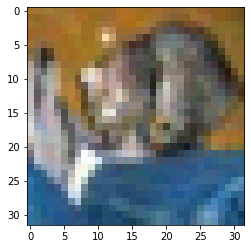

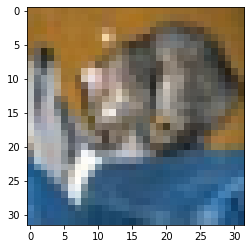

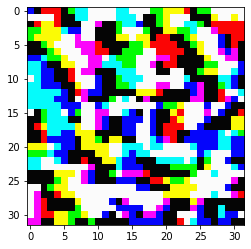

In [ ]:
plt.imshow((x_test_adv_fgsm[0]*255).astype(np.uint8)) 
plt.show()

plt.imshow((x_test[0]*255).astype(np.uint8))
plt.show()

plt.imshow(((x_test_adv_fgsm[0] - x_test[0])*255).astype(np.uint8))
plt.show()

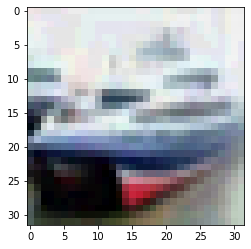

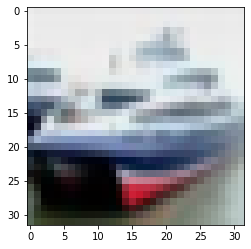

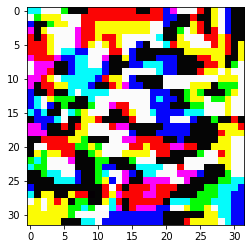

In [ ]:
plt.imshow((x_test_adv_fgsm[1]*255).astype(np.uint8))
plt.show()

plt.imshow((x_test[1]*255).astype(np.uint8))
plt.show()

plt.imshow(((x_test_adv_fgsm[1] - x_test[1])*255).astype(np.uint8))
plt.show()

**checking wrongly predicting**

In [ ]:
print("incorrect label after atack:",np.argmax(brute_model.predict(np.expand_dims(x_test_adv_fgsm[0],axis=0))))

print("corect label:", np.argmax(brute_model.predict(np.expand_dims(x_test[0],axis=0))))

incorrect label after atack: 5
corect label: 3


**accuracy after FGSM attack**

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),np.argmax(brute_model.predict(x_test_adv_fgsm),axis=1))*100,"%")

print("confusion_matrix:\n",confusion_matrix(np.argmax(y_test,axis=1),np.argmax(brute_model.predict(x_test_adv_fgsm),axis=1)))


test accuracy: 26.9275 %
confusion_matrix:
 [[1176  145  861  110  285   29   39  135 1003  217]
 [ 193 1592  114   72   65   38   90   51  509 1276]
 [ 416   74 1100  481  646  428  414  254  143   44]
 [ 117   56  508  835  373  929  442  382  219  139]
 [ 149   35  958  355  754  280  460  870   86   53]
 [  62   54  687 1006  270  994  228  566   95   38]
 [  64  127  686  761  668  460  841  178   96  119]
 [ 207   38  340  343  772  622   88 1289   74  227]
 [1217  531  244  198   91   45   79   74 1109  412]
 [ 387 1152  127  161   38   79  100  458  417 1081]]


In [ ]:
np.save("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test_adv_fgsm_after_adversarial_training.npy",x_test_adv_fgsm)

In [ ]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim(x_test,x_test_adv_fgsm):
  
  all_ssims = 0
  for i in range(len(x_test)):
    all_ssims += ssim(x_test[i],x_test_adv_fgsm[i], data_range=x_test_adv_fgsm[2].max() - x_test_adv_fgsm[2].min(), multichannel=True)

  print("Avaerage SSIM:",all_ssims/len(x_test))



In [ ]:
mean_ssim(x_test,x_test_adv_fgsm)

Avaerage SSIM: 0.9704823106868291


# PGD Attack Attack After Adversarial Training

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(model=brute_model_adv, nb_classes=10, input_shape=(32, 32, 3), loss_object=loss_object,clip_values=(0, 1), channels_first=False)

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier,eps=0.02,batch_size=32)
x_test_adv_pgd = attack_pgd.generate(x_test)
print(x_test_adv_pgd.shape)

PGD - Batches: 0it [00:00, ?it/s]

(40000, 32, 32, 3)


In [ ]:
np.save("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test_adv_pgd_after_adversarial_training.npy",x_test_adv_pgd)

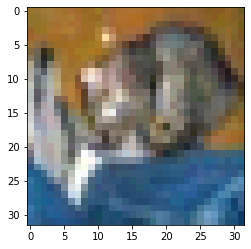

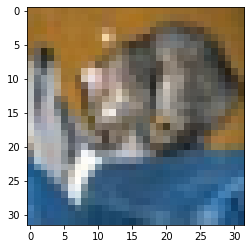

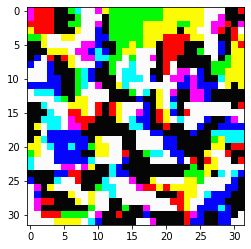

In [ ]:
plt.imshow((x_test_adv_pgd[0]*255).astype(np.uint8)) 
plt.show()

plt.imshow((x_test[0]*255).astype(np.uint8))
plt.show()

plt.imshow(((x_test_adv_pgd[0] - x_test[0])*255).astype(np.uint8))
plt.show()

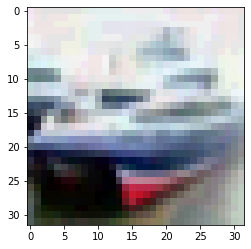

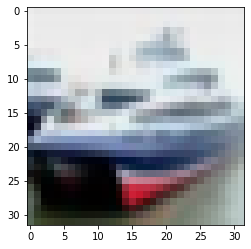

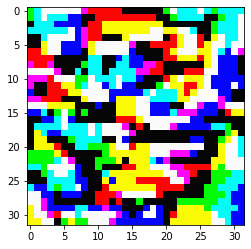

In [ ]:
plt.imshow((x_test_adv_pgd[1]*255).astype(np.uint8))
plt.show()

plt.imshow((x_test[1]*255).astype(np.uint8))
plt.show()

plt.imshow(((x_test_adv_pgd[1] - x_test[1])*255).astype(np.uint8))
plt.show()

**checking wrongly predicting**


In [ ]:
print("incorrect label after atack:",np.argmax(brute_model.predict(np.expand_dims(x_test_adv_pgd[0],axis=0))))

print("corect label:", np.argmax(brute_model.predict(np.expand_dims(x_test[0],axis=0))))

incorrect label after atack: 5
corect label: 3


**accuracy after PGD attack**

In [ ]:
from sklearn.metrics import accuracy_score
print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),np.argmax(brute_model.predict(x_test_adv_pgd),axis=1))*100,"%")

print("confusion_matrix:\n",confusion_matrix(np.argmax(y_test,axis=1),np.argmax(brute_model.predict(x_test_adv_pgd),axis=1)))


test accuracy: 25.4325 %
confusion_matrix:
 [[1131  168  789  103  306   27   51  162 1051  212]
 [ 211 1393  129   80   66   38   79   62  555 1387]
 [ 360   96 1106  430  630  390  436  355  155   42]
 [  98   72  501  736  371  893  487  470  203  169]
 [ 117   43  944  337  715  254  504  905  117   64]
 [  62   61  692  956  265  948  252  620   88   56]
 [  73  125  624  618  709  447  879  287   98  140]
 [ 180   59  402  353  704  539  123 1307   78  255]
 [1359  529  283  135  108   42   80   87  953  424]
 [ 371 1220  146  124   64   79  117  463  411 1005]]


In [ ]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim(x_test,x_test_adv_pgd):
  
  all_ssims = 0
  for i in range(len(x_test)):
    all_ssims += ssim(x_test[i],x_test_adv_pgd[i], data_range=x_test_adv_pgd[2].max() - x_test_adv_pgd[2].min(), multichannel=True)

  print("Avaerage SSIM:",all_ssims/len(x_test))



In [ ]:
mean_ssim(x_test,x_test_adv_pgd)

Avaerage SSIM: 0.9702700729575591


#BIM Attack After Adversarial Training

In [ ]:
## mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(model=brute_model_adv, nb_classes=10, input_shape=(32, 32, 3), loss_object=loss_object,clip_values=(0, 1), channels_first=False)

In [30]:
attack_bim = BasicIterativeMethod(estimator=classifier,eps=0.02,batch_size=32)
x_test_adv_bim = attack_bim.generate(x_test)
print(x_test_adv_bim.shape)

PGD - Batches: 0it [00:00, ?it/s]

(40000, 32, 32, 3)


In [31]:
np.save("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test_adv_bim_after_adversarial_training.npy",x_test_adv_bim)

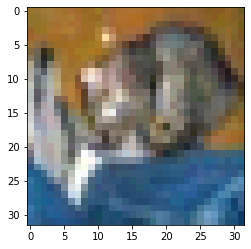

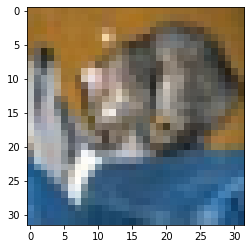

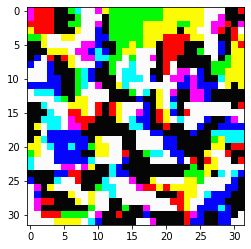

In [32]:
plt.imshow((x_test_adv_bim[0]*255).astype(np.uint8)) 
plt.show()

plt.imshow((x_test[0]*255).astype(np.uint8))
plt.show()

plt.imshow(((x_test_adv_bim[0] - x_test[0])*255).astype(np.uint8))
plt.show()

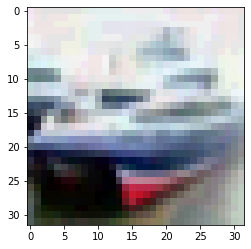

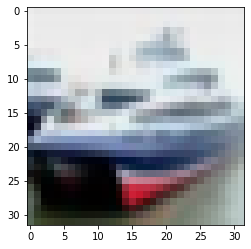

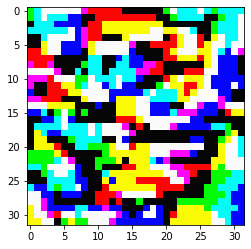

In [33]:
plt.imshow((x_test_adv_bim[1]*255).astype(np.uint8))
plt.show()

plt.imshow((x_test[1]*255).astype(np.uint8))
plt.show()

plt.imshow(((x_test_adv_bim[1] - x_test[1])*255).astype(np.uint8))
plt.show()

**checking wrongly predicting**


In [34]:
print("incorrect label after atack:",np.argmax(brute_model.predict(np.expand_dims(x_test_adv_bim[0],axis=0))))

print("corect label:", np.argmax(brute_model.predict(np.expand_dims(x_test[0],axis=0))))

incorrect label after atack: 5
corect label: 3


**Accuracy after BIM attack**

In [35]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),np.argmax(brute_model.predict(x_test_adv_bim),axis=1))*100,"%")

print("confusion_matrix:\n",confusion_matrix(np.argmax(y_test,axis=1),np.argmax(brute_model.predict(x_test_adv_bim),axis=1)))


test accuracy: 25.4325 %
confusion_matrix:
 [[1131  168  789  103  306   27   51  162 1051  212]
 [ 211 1393  129   80   66   38   79   62  555 1387]
 [ 360   96 1106  430  630  390  436  355  155   42]
 [  98   72  501  736  371  893  487  470  203  169]
 [ 117   43  944  337  715  254  505  905  116   64]
 [  62   61  691  957  265  948  252  620   88   56]
 [  73  125  624  618  709  447  879  287   98  140]
 [ 180   59  402  353  704  539  123 1307   78  255]
 [1359  529  283  135  108   42   80   87  953  424]
 [ 371 1220  146  124   64   79  117  463  411 1005]]


In [ ]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim(x_test,x_test_adv_bim):
  
  all_ssims = 0
  for i in range(len(x_test)):
    all_ssims += ssim(x_test[i],x_test_adv_bim[i], data_range=x_test_adv_bim[2].max() - x_test_adv_bim[2].min(), multichannel=True)

  print("Avaerage SSIM:",all_ssims/len(x_test))


In [37]:
mean_ssim(x_test,x_test_adv_bim)

Avaerage SSIM: 0.9702701644967517


# Perturbation magnitude histogram Attack After Adversarial Training

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
def Magnitude_of_perturbation(x_test_adversarial,x_test_original):

  histo_array = []
  histo_dict = dict()

  for i in range(len(x_test_original)):
    
    mean_perturbation = np.mean(np.abs(x_test_adversarial[i] - x_test_original[i]))
    histo_array.append(mean_perturbation)
    if np.round(mean_perturbation,3) not in histo_dict:
      histo_dict[np.round(mean_perturbation,3)] = 1

    elif np.round(mean_perturbation,3) in histo_dict:
      histo_dict[np.round(mean_perturbation,3)] += 1

  print(histo_dict)
  plt.hist(histo_array)
  plt.show()

**FGSM**

In [7]:
x_test = np.load("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test.npy")
x_test_adv_fgsm = np.load("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test_adv_fgsm_after_adversarial_training.npy")

{0.02: 8978, 0.019: 588, 0.017: 109, 0.016: 69, 0.014: 19, 0.018: 188, 0.013: 6, 0.015: 41, 0.012: 2}


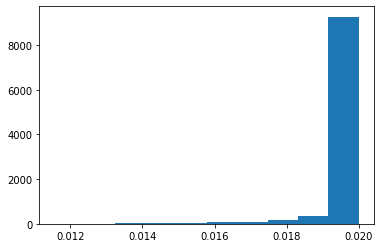

In [8]:
Magnitude_of_perturbation(x_test_adv_fgsm,x_test)

**PGD**

In [9]:
x_test_adv_pgd = np.load("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test_adv_pgd_after_adversarial_training.npy") 


{0.02: 8977, 0.019: 596, 0.017: 109, 0.014: 18, 0.018: 191, 0.016: 65, 0.015: 36, 0.013: 7, 0.011: 1}


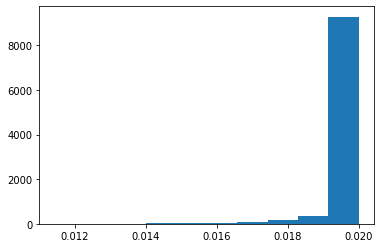

In [10]:
Magnitude_of_perturbation(x_test_adv_pgd,x_test)

**BIM**

In [11]:
x_test_adv_bim = np.load("/content/drive/MyDrive/vgg16_cifar10_PA2_dataset/x_test_adv_bim_after_adversarial_training.npy") 

{0.02: 8977, 0.019: 596, 0.017: 109, 0.014: 18, 0.018: 191, 0.016: 65, 0.015: 36, 0.013: 7, 0.011: 1}


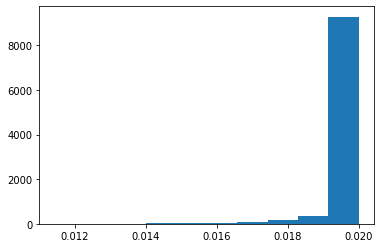

In [12]:
Magnitude_of_perturbation(x_test_adv_bim,x_test)